In [1]:
from src.base import Block, Boxtype
import src.vcs_function as eval
import src.box_plotter as bxplot
import time
import pandas as pd

#test Blocks
b1 = Block(boxtype=Boxtype(1,2,4,True,True,True,1), rot='wlh')
b2 = Block(boxtype=Boxtype(1,2,3,True,True,True,1), rot='lwh')
b3 = Block(boxtype=Boxtype(1,1,2,True,True,True,1), rot='hwl')

#test join
print("b1:",b1); print("b2:",b2); print("b3:",b3)
t=b1.join(b2, 'y'); print(t,"b1+b2:",b1)
t=b1.join(b3, 'z'); print(t,"b1+b3:",b1)
t=b1.join(b1, 'x'); print(t,"b1+b1:",b1)

b1: Block: l: 4 w: 2 h: True weight: 1 volume: 8 occupied_volume: 8 items: {<src.base.Boxtype object at 0x0000027E83EE6A40>: 1} ratio:1.0
b2: Block: l: 2 w: 3 h: True weight: 1 volume: 6 occupied_volume: 6 items: {<src.base.Boxtype object at 0x0000027E8386FC10>: 1} ratio:1.0
b3: Block: l: True w: 2 h: 1 weight: 1 volume: 2 occupied_volume: 2 items: {<src.base.Boxtype object at 0x0000027E83F43070>: 1} ratio:1.0
False b1+b2: Block: l: 4 w: 2 h: True weight: 1 volume: 8 occupied_volume: 8 items: {<src.base.Boxtype object at 0x0000027E83EE6A40>: 1} ratio:1.0
False b1+b3: Block: l: 4 w: 2 h: True weight: 1 volume: 8 occupied_volume: 8 items: {<src.base.Boxtype object at 0x0000027E83EE6A40>: 1} ratio:1.0
True b1+b1: Block: l: 8 w: 2 h: True weight: 2 volume: 16 occupied_volume: 16 items: {<src.base.Boxtype object at 0x0000027E83EE6A40>: 2} ratio:1.0


## Plot container

In [2]:
def load_instance(filename = "instancia.txt", type="BF", id_instance=5):
    with open(filename, "r") as file:
        #discard first line
        file.readline()
      
        for j in range(100):
            file.readline()
            L, W, H, WEIGHT,SUPPORTED_WEIGHT = [int(x) for x in file.readline().split()]

            #read second line
            n = int(file.readline())
            #read n lines
            items = Itemdict()
            for i in range(n):
                id, l, rotx, w, roty, h, rotz, n, weight, supported_weight = [int(x) for x in file.readline().split()]    
                item = Boxtype(id, l, w, h, rotx, roty, rotz, weight, supported_weight)
                items[item]=n
            
            if j == id_instance: return  items, L, W, H, WEIGHT, SUPPORTED_WEIGHT

In [3]:
def adyacent_blocks(blocks,L,W,H):
    last = blocks[-1]
    adyacent = list()
    box_dims = []
    
    for block in blocks[:-1]:
        
        if block.xmax == last.xmin and ((block.zmin < last.zmax and block.zmax > last.zmin ) and (block.ymin < last.ymax and block.ymax > last.ymin )):
            z_diff_max = max([block.zmin,last.zmin])
            z_diff_min = min([block.zmax,last.zmax])
            y_diff_max = max([block.ymin,last.ymin])
            y_diff_min = min([block.ymax,last.ymax])
            adyacent.append(block)
            block.covered_surface+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            block.covered_surface_face['X1']+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            last.covered_surface+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            last.covered_surface_face['X2']+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)

        elif block.xmin == last.xmax and ((block.zmin < last.zmax and block.zmax > last.zmin ) and (block.ymin < last.ymax and block.ymax > last.ymin )):
            z_diff_max = max([block.zmin,last.zmin])
            z_diff_min = min([block.zmax,last.zmax])
            y_diff_max = max([block.ymin,last.ymin])
            y_diff_min = min([block.ymax,last.ymax])
            adyacent.append(block)
            block.covered_surface+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            block.covered_surface_face['X2']+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            last.covered_surface+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            last.covered_surface_face['X1']+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)

        elif block.ymax == last.ymin and ((block.zmin < last.zmax and block.zmax > last.zmin ) and (block.xmin < last.xmax and block.xmax > last.xmin )):
            z_diff_max = max([block.zmin,last.zmin])
            z_diff_min = min([block.zmax,last.zmax])
            x_diff_max = max([block.xmin,last.xmin])
            x_diff_min = min([block.xmax,last.xmax])
            adyacent.append(block)
            block.covered_surface+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            block.covered_surface_face['Y1']+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface_face['Y2']+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)

        elif block.ymin == last.ymax and ((block.zmin < last.zmax and block.zmax > last.zmin ) and (block.xmin < last.xmax and block.xmax > last.xmin )):
            z_diff_max = max([block.zmin,last.zmin])
            z_diff_min = min([block.zmax,last.zmax])
            x_diff_max = max([block.xmin,last.xmin])
            x_diff_min = min([block.xmax,last.xmax])
            adyacent.append(block)
            block.covered_surface+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            block.covered_surface_face['Y2']+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface_face['Y1']+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)

        elif block.zmax == last.zmin and ((block.ymin < last.ymax and block.ymax > last.ymin ) and (block.xmin < last.xmax and block.xmax > last.xmin )):
            y_diff_max = max([block.ymin,last.ymin])
            y_diff_min = min([block.ymax,last.ymax])
            x_diff_max = max([block.xmin,last.xmin])
            x_diff_min = min([block.xmax,last.xmax])
            adyacent.append(block)
            block.covered_surface+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            # block.covered_surface_face['Z1']+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            # last.covered_surface_face['Z2']+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)

        elif block.zmin == last.zmax and ((block.ymin < last.ymax and block.ymax > last.ymin ) and (block.xmin < last.xmax and block.xmax > last.xmin )):
            y_diff_max = max([block.ymin,last.ymin])
            y_diff_min = min([block.ymax,last.ymax])
            x_diff_max = max([block.xmin,last.xmin])
            x_diff_min = min([block.xmax,last.xmax])
            adyacent.append(block)
            block.covered_surface+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            # block.covered_surface_face['Z2']+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            # last.covered_surface_face['Z1']+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            
    # if(len(adyacent)!=0):
        # print(last.covered_surface_face)
        # box_dims.append([last.xmin,last.ymin,last.zmin,last.xmax,last.ymax,last.zmax])
        # for aabb in adyacent:
        #     box_dims.append([aabb.xmin,aabb.ymin,aabb.zmin,aabb.xmax,aabb.ymax,aabb.zmax])
        # bxplot.plot_container([L,W,H], box_dims)
    pass

# The main code

In [4]:

from src.base import Itemdict, BlockList, Aabb, Space
from src.restrictions import center_of_gravity

def MLCP_function(alpha,beta,gamma,delta,p,instance):

  start_time = time.time()

  params = [alpha,beta,gamma,delta,p]

  Space.filling = "bottom-up" # spaces are filled from bottom to top
  Space.vertical_stability = True # boxes must be completly supported

  items, L, W, H, WEIGHT,SUPPORTED_WEIGHT = load_instance(filename = "src/BR4.txt", type="BF", id_instance=instance)

  cont = Block(l=L,w=W,h=H,weight=WEIGHT,stacking_weight_resistance=SUPPORTED_WEIGHT)

  # print("generating blocks...")
  blocks = BlockList(items, type="general_blocks", cont=cont, min_fr=1.0, max_bl=1000) 

  # for x in blocks:
  #    print(x.items.values())

  # greedy for single CLP
  while True:
      space = cont.free_space.closest_space() #cuboide mas cercano a un vertice inferior del contenedor

      if space is not None:
        block = eval.eval_function(blocks,space,params=params,container=cont,items=items)
        # print("adding block...", block)
        
        cont.add_block(block, space)
        adyacent_blocks(cont.aabbs,L,W,H)
        items -= block.items
        blocks.remove_unconstructable(items)
        cont.free_space.filter(items)
      else:
          break

  end_time = time.time()

  execution_time = end_time - start_time

  total_volume = sum([x.volume for x in cont.aabbs])

  return cont,execution_time,total_volume

  # print(f'tiempo: {execution_time} s ; volumen total: {cont.l * cont.w * cont.h} ; volumen ocupado: {total_volume} ; centro de gravedad: {center_of_gravity(cont)}')


# Plot the solution

In [5]:
cont, execution_time,total_volume = MLCP_function(alpha=4.0,beta=1.0,gamma=0.2,delta=0.5,p=0.05,instance=1)

L = cont.l;W = cont.w; H = cont.h

box_dims = []
for aabb in cont.aabbs:
  box_dims.append([aabb.xmin,aabb.ymin,aabb.zmin,aabb.xmax,aabb.ymax,aabb.zmax])

bxplot.plot_container([L,W,H], box_dims)


In [6]:
ALPHA = [0.0,1.0,2.0,3.0]
BETA = [0.0,1.0,2.0,3.0]
GAMMA = [0.0,0.1,0.2,0.3]
DELTA = [0.0,0.2,0.4,0.6]
P = [0.00,0.01,0.02,0.03]
INSTANCE = [1,2,3]

In [7]:
# data = []
# for i in INSTANCE:
#     for a in ALPHA:
#         for b in BETA:
#             for g in GAMMA:
#                 for d in DELTA:
#                     for p in P:
#                         cont, execution_time,total_volume = MLCP_function(a,b,g,d,p,i)
#                         data.append([i,execution_time,total_volume,center_of_gravity(cont),a,b,g,d,p])


In [8]:
df = pd.DataFrame(data,columns=['Instancia','Tiempo ejecucion','Volumen Ocupado','Diferencia centro','alpha','beta','gamma','delta','p'])

NameError: name 'data' is not defined

In [ ]:
df

,Instancia,Tiempo ejecucion,Volumen Ocupado,Diferencia centro,alpha,beta,gamma,delta,p
0,1,0.312116,21574535,15.404030,0.0,0.0,0.0,0.0,0.00
1,1,0.309088,21574535,15.404030,0.0,0.0,0.0,0.0,0.01
2,1,0.304783,21574535,15.404030,0.0,0.0,0.0,0.0,0.02
3,1,0.320799,21574535,15.404030,0.0,0.0,0.0,0.0,0.03
4,1,0.341303,23911333,9.415666,0.0,0.0,0.0,0.2,0.00
...,...,...,...,...,...,...,...,...,...
3067,3,0.276325,14974841,22.736535,3.0,3.0,0.3,0.4,0.03
3068,3,0.277891,15525209,10.332596,3.0,3.0,0.3,0.6,0.00
3069,3,0.301094,15525209,10.332596,3.0,3.0,0.3,0.6,0.01
3070,3,0.278081,15525209,10.332596,3.0,3.0,0.3,0.6,0.02


In [ ]:
df.to_csv('resultados_parametros2.csv')

In [ ]:
df.loc[df['Instancia']==1]

,Instancia,Tiempo ejecucion,Volumen Ocupado,Diferencia centro,alpha,beta,gamma,delta,p
0,1,0.312116,21574535,15.404030,0.0,0.0,0.0,0.0,0.00
1,1,0.309088,21574535,15.404030,0.0,0.0,0.0,0.0,0.01
2,1,0.304783,21574535,15.404030,0.0,0.0,0.0,0.0,0.02
3,1,0.320799,21574535,15.404030,0.0,0.0,0.0,0.0,0.03
4,1,0.341303,23911333,9.415666,0.0,0.0,0.0,0.2,0.00
...,...,...,...,...,...,...,...,...,...
1019,1,0.325201,15104111,25.876565,3.0,3.0,0.3,0.4,0.03
1020,1,0.354358,14415467,23.559681,3.0,3.0,0.3,0.6,0.00
1021,1,0.347532,14415467,23.559681,3.0,3.0,0.3,0.6,0.01
1022,1,0.351308,16419435,17.940611,3.0,3.0,0.3,0.6,0.02


In [ ]:

df.loc[df['Instancia']==1].sort_values(by=['Volumen Ocupado'])

,Instancia,Tiempo ejecucion,Volumen Ocupado,Diferencia centro,alpha,beta,gamma,delta,p
465,1,0.317558,12123861,21.046960,1.0,3.0,0.1,0.0,0.01
464,1,0.318378,12123861,21.046960,1.0,3.0,0.1,0.0,0.00
642,1,0.301005,12265275,49.710424,2.0,2.0,0.0,0.0,0.02
725,1,0.302309,12265275,32.802873,2.0,3.0,0.1,0.2,0.01
726,1,0.310232,12265275,34.706605,2.0,3.0,0.1,0.2,0.02
...,...,...,...,...,...,...,...,...,...
45,1,0.351066,24927943,9.767508,0.0,0.0,0.2,0.6,0.01
30,1,0.366199,24927943,9.767508,0.0,0.0,0.1,0.6,0.02
31,1,0.363962,24927943,9.767508,0.0,0.0,0.1,0.6,0.03
60,1,0.352230,24927943,9.767508,0.0,0.0,0.3,0.6,0.00


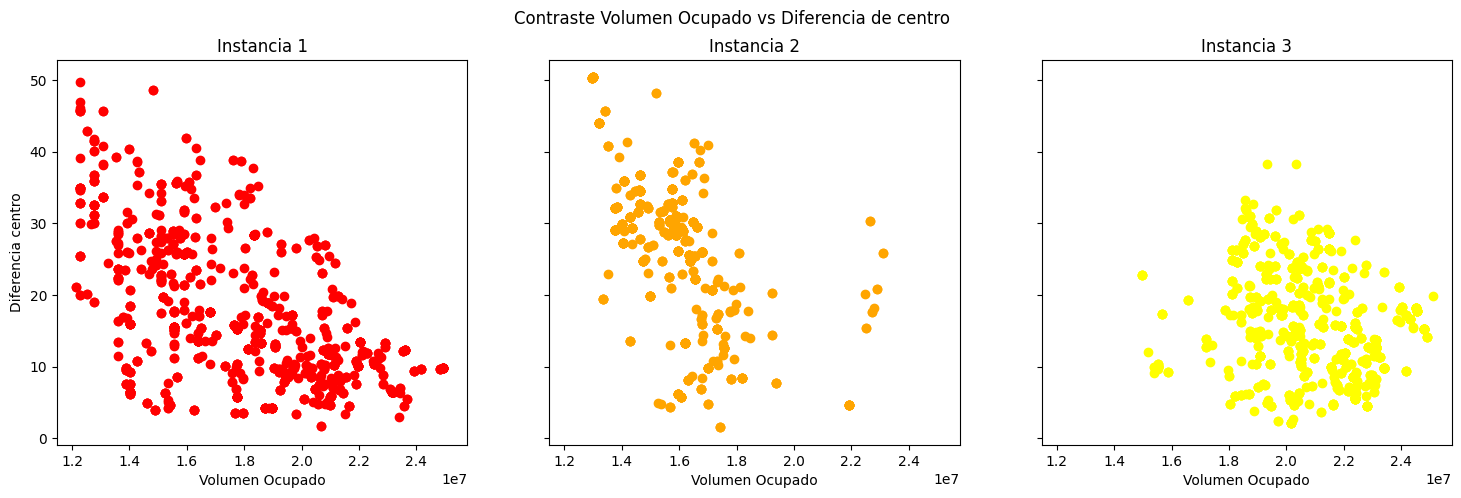

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3,figsize=(18,5),sharex=True,sharey=True)
ax[0].scatter(df['Volumen Ocupado'].loc[df['Instancia']==1],df['Diferencia centro'].loc[df['Instancia']==1], c='#FF0000')
ax[0].set_xlabel('Volumen Ocupado');ax[0].set_ylabel('Diferencia centro')
ax[0].set_title('Instancia 1')
ax[1].scatter(df['Volumen Ocupado'].loc[df['Instancia']==2],df['Diferencia centro'].loc[df['Instancia']==2], c='#FFA500')
ax[1].set_xlabel('Volumen Ocupado');ax[0].set_ylabel('Diferencia centro')
ax[1].set_title('Instancia 2')
ax[2].scatter(df['Volumen Ocupado'].loc[df['Instancia']==3],df['Diferencia centro'].loc[df['Instancia']==3], c='#FFFF00')
ax[2].set_xlabel('Volumen Ocupado');ax[0].set_ylabel('Diferencia centro')
ax[2].set_title('Instancia 3')
plt.suptitle('Contraste Volumen Ocupado vs Diferencia de centro')

plt.savefig('volumen vs centro.jpg')

In [ ]:
print(df['Diferencia centro'][df['Instancia']==1].mean())
print(df['Diferencia centro'][df['Instancia']==2].mean())
print(df['Diferencia centro'][df['Instancia']==3].mean())

16.950031214217052
27.446707594565346
15.45763361867423


In [ ]:
print(df['Volumen Ocupado'][df['Instancia']==1].mean())
print(df['Volumen Ocupado'][df['Instancia']==2].mean())
print(df['Volumen Ocupado'][df['Instancia']==3].mean())

17943131.474609375
15769466.397460938
21052055.7265625


In [ ]:
print(df['Tiempo ejecucion'][df['Instancia']==1].mean())
print(df['Tiempo ejecucion'][df['Instancia']==2].mean())
print(df['Tiempo ejecucion'][df['Instancia']==3].mean())

0.3360172517132014
0.2620725226588547
0.3105088521260768


In [ ]:
best_instances = df.groupby('Instancia')['Volumen Ocupado'].max().reset_index()
merged_df = pd.merge(best_instances,df,on=['Instancia','Volumen Ocupado'])

In [14]:
# cont, execution_time,total_volume = MLCP_function(alpha=1.0,beta=0.0,gamma=0,delta=0,p=0,instance=2)
cont, execution_time,total_volume = MLCP_function(alpha=1.0,beta=3.0,gamma=0.1,delta=0.2,p=0.02,instance=2)

L = cont.l;W = cont.w; H = cont.h

box_dims = []
for aabb in cont.aabbs:
  box_dims.append([aabb.xmin,aabb.ymin,aabb.zmin,aabb.xmax,aabb.ymax,aabb.zmax])

bxplot.plot_container([L,W,H], box_dims)

In [15]:
print(f'centro: {center_of_gravity(cont)} tiempo:{execution_time} volumen:{total_volume}')

centro: 22.283731016624227 tiempo:0.25870537757873535 volumen:16558688


In [16]:
print(f'centro: {center_of_gravity(cont)} tiempo:{execution_time} volumen:{total_volume}')

centro: 22.283731016624227 tiempo:0.25870537757873535 volumen:16558688
